In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd

import data_pre_processing
import dataset_pre_processing
import pre_training
import raw_data_processing
from raw_data_processing import process_PAMAP2_all_data, process_hhar_all_files, process_motion_sense_all_files, open_pickle
import numpy as np
import scipy.stats
import data_pre_processing
import self_har_models
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

tf.get_logger().setLevel('INFO')

# Data pre-processing

In [2]:
# get data from pickle 

with open('pickled_datasets/pamap2.pickle', 'rb') as file:
    pamap_df = pickle.load(file)
with open('pickled_datasets/hhar2.pickle', 'rb') as file:
    hhar_df = pickle.load(file)
with open('pickled_datasets/motionsense2.pickle', 'rb') as file:
    motion_sense_df = pickle.load(file)
    
def concat_datasets(datasets, sensor_type):
    concated_datasets = {}
    ##TODO need to check key to see whether mag exists
    for df in datasets:
        concated_datasets.update(df[sensor_type])
    return concated_datasets

cdf = concat_datasets([pamap_df, hhar_df, motion_sense_df], "all")
def get_labels(data):
    all_labels = []
    for user in data:
        all_labels = np.concatenate((np.unique(data[user][0][1]), all_labels))
    labels = np.unique(all_labels)
    return labels

labels = get_labels(cdf)
label_map = {label: index for index, label in enumerate(labels)}
print(label_map)
user_datasets_processed = data_pre_processing.pre_process_dataset_composite(
    cdf, label_map, 14, 
    ['101', '102', '103', '104', '105', '106', '107', 'a', 'b', 'c', 'd', 'e', 'f', 'g', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'], 
    ["108", "109", "h", "i", "21", "22", "23", "24"], 400, 200
)

{'IMU ankle acc': 0, 'IMU ankle gyro': 1, 'IMU ankle mag': 2, 'IMU chest acc': 3, 'IMU chest gyro': 4, 'IMU chest mag': 5, 'IMU hand acc': 6, 'IMU hand gyro': 7, 'IMU hand mag': 8, 'Phone acc': 9, 'Phone gyro': 10, 'Watch acc': 11, 'Watch gyro': 12, 'iphone Acc': 13}
getting mean
[-0.5407976  -1.98511375  1.75847852]
[12.59890847 11.8476798  11.12922508]
normalising train set
normalisnig test


In [3]:
# implement early stopping
callback = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Create Transformer Model

In [4]:
inputs = tf.keras.Input(shape=(400,3), name='input')
# inputs = (400, 3)
x = inputs
x = tf.keras.layers.MultiHeadAttention(
    key_dim=512,
    num_heads=16,
    dropout=0.25,
)(x, x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
res = x + inputs

x = tf.keras.layers.Dense(128 , activation='relu')(res)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
x = tf.keras.layers.Dense(3)(x)
x = x + res
x = tf.keras.layers.GlobalMaxPool1D(data_format='channels_last', name='global_max_pooling1d')(x) 
x = tf.keras.layers.Dense(14, activation='softmax')(x)

outputs = tf.keras.layers.Softmax()(x)

model2 = tf.keras.Model(inputs, outputs)
model2.summary()

model2.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.005),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy"), tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 400, 3)]     0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 400, 3)      122883      ['input[0][0]',                  
 dAttention)                                                      'input[0][0]']                  
                                                                                                  
 dropout (Dropout)              (None, 400, 3)       0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 400, 3)      6           ['dropout[0][0]']            

In [7]:
CNNLSTM_history = model2.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=100, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]), callbacks=[callback])

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
import matplotlib.pyplot as plt
plt.plot(CNNLSTM_history.history['categorical_accuracy'], label='accuracy')
plt.plot(CNNLSTM_history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.7, 1])
plt.legend(loc='lower right')
plt.show()

lstm_test_result = model2.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)
predicted_labels = np.argmax(model2.predict(user_datasets_processed[2][0]), axis=1)
true_labels = np.argmax(user_datasets_processed[2][1], axis=1)
confusion_mat = tf.math.confusion_matrix(true_labels, predicted_labels)
cm = confusion_mat.numpy()
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [79]:
model2.save("Transformer1")

INFO:tensorflow:Assets written to: Transformer1/assets


INFO:tensorflow:Assets written to: Transformer1/assets


In [10]:
model = tf.keras.models.load_model('CNN-LSTM')

In [11]:
lstm_test_result = model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)


660/660 [==============================] - 4s 4ms/step - loss: 0.6365 - categorical_accuracy: 0.8919 - auc: 0.9527 - precision: 0.8922 - recall: 0.8888


# Downstream Train

In [8]:
with open('pickled_datasets/hhar_HAR.pickle', 'rb') as file:
    hhar_df = pickle.load(file)
core_model = self_har_models.extract_core_model(full_CNNLSTM_model)
def get_labels(data):
    all_labels = []
    for user in data:
        all_labels = np.concatenate((np.unique(data[user][0][1]), all_labels))
    labels = np.unique(all_labels)
    return labels

labels = get_labels(hhar_df)
label_map = {label: index for index, label in enumerate(labels)}
print(label_map)
user_datasets_processed = data_pre_processing.pre_process_dataset_composite(
hhar_df, label_map, 6,
    ['a', 'b', 'c', 'd', 'e', 'f', 'g'],
['h', 'i'], 400, 200)
full_CNNLSTM_model = self_har_models.attach_full_har_classification_head(core_model, 6, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
CNNLSTM_history = full_CNNLSTM_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=100, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]), callbacks=[callback])

{'bike': 0, 'sit': 1, 'stairsdown': 2, 'stairsup': 3, 'stand': 4, 'walk': 5}
getting mean
[-1.53514467  0.15958888  8.87110299]
[4.05960663 1.57266006 2.32821487]
normalising train set
normalisnig test
Epoch 1/100
1089/1089 [==============================] - 13s 9ms/step - loss: 0.7856 - categorical_accuracy: 0.6507 - auc: 0.9340 - precision: 0.9335 - recall: 0.4402 - val_loss: 0.6721 - val_categorical_accuracy: 0.6734 - val_auc: 0.9471 - val_precision: 0.9741 - val_recall: 0.4800
Epoch 2/100
1089/1089 [==============================] - 9s 9ms/step - loss: 0.6782 - categorical_accuracy: 0.6756 - auc: 0.9464 - precision: 0.9607 - recall: 0.4791 - val_loss: 0.6474 - val_categorical_accuracy: 0.6838 - val_auc: 0.9500 - val_precision: 0.9705 - val_recall: 0.4905
Epoch 3/100
1089/1089 [==============================] - 9s 9ms/step - loss: 0.6592 - categorical_accuracy: 0.6810 - auc: 0.9486 - precision: 0.9670 - recall: 0.4831 - val_loss: 0.6213 - val_categorical_accuracy: 0.7105 - val_auc: 

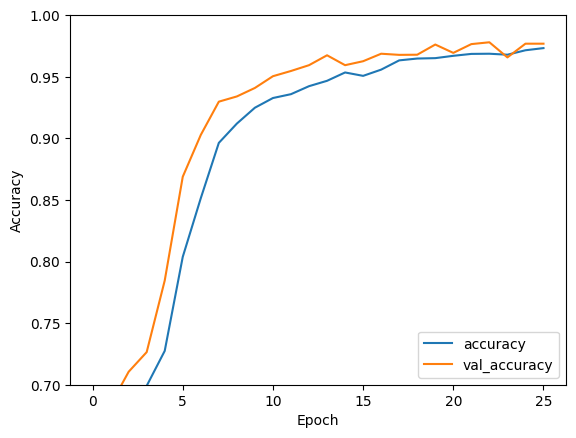

401/401 [==============================] - 2s 3ms/step


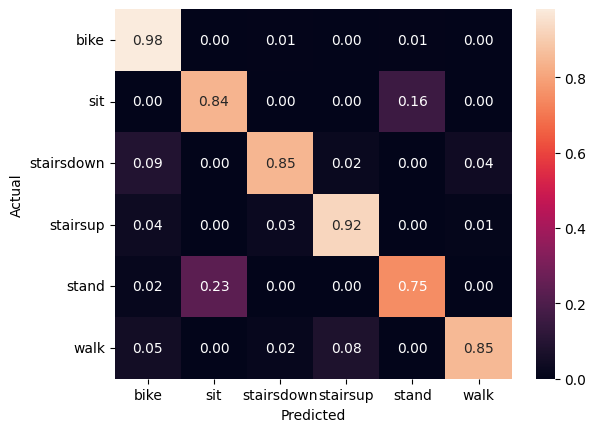

In [10]:
import matplotlib.pyplot as plt
plt.plot(CNNLSTM_history.history['categorical_accuracy'], label='accuracy')
plt.plot(CNNLSTM_history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.7, 1])
plt.legend(loc='lower right')
plt.show()

lstm_test_result = full_CNNLSTM_model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)
predicted_labels = np.argmax(full_CNNLSTM_model.predict(user_datasets_processed[2][0]), axis=1)
true_labels = np.argmax(user_datasets_processed[2][1], axis=1)
confusion_mat = tf.math.confusion_matrix(true_labels, predicted_labels)
cm = confusion_mat.numpy()
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)